<h1> Laboratory work 1:  Text classification </h1>

Authors: Alexei Trutnev, Frolova Olga

## Exploratory data analysis

<h3> Dataset descriptions </h3>

The dataset <a href="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data" target="_blank">  Twitter Sentiment Analysis </a> is used.

In this laboratory work, we explore the fundamental principles of text classification using natural language processing (NLP) techniques. Text classification is one of the core tasks in NLP and has broad applications in areas such as sentiment analysis, spam detection, and document categorization. The objective of this task is to automatically categorize textual data into predefined classes based on its content.

We will focus on sentiment analysis, a popular application of text classification, where the goal is to determine the sentiment expressed in a piece of text. Specifically, we will be working with a real-world dataset from Twitter that contains messages mentioning specific entities. Our task is to classify the sentiment of each message towards the mentioned entity as <b>Positive</b>, <b>Negative</b>, <b>Neutral</b> or <b>Irrelevant</b>.


In [1]:
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, Trainer, TrainingArguments

from src.classification.classical_ml import (ClassicClassification,
                                             ClassicClassificationType)
from src.classification.deep_ml import (LSTMClassifier, RNNClassifier,
                                        compute_metrics, prepare_dataset)
from src.classification.quality import estimate_quality
from src.preprocessing import (convert_to_lowercase, load_dataset,
                               normalization_text, remove_extra_spaces,
                               remove_special_characters, remove_stop_words,
                               removing_digits, set_seed)
from src.utils import dump_dict, get_subset
from src.vectorizer import Vectorizer, VectorizerType
from src.visualization import (distribution_chart,
                               generate_sentiment_wordclouds,
                               sentiment_distribution_chart)

set_seed()

/Users/olgafrolova/Documents/ВШЭ/магистратура(2 курс)/Компьютерная лингвистика(Санжар)/nlp-classification/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/olgafrolova/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgafrolova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_path = Path('data/twitter_training.csv')
df = load_dataset(train_path)

## EDA

In [3]:
df.head(10)

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


### Check the empty and irrelevant data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


The DataFrame contains 74,682 entries with 4 columns in total:

* <b>id</b>: Contains unique identifiers for each entry; all 74,682 entries are non-null integers.

* <b>entity</b>: Specifies the entity associated with each entry; all 74,682 entries are non-null objects.

* <b>sentiment</b>: Indicates the sentiment label for each entry; all 74,682 entries are non-null objects.

* <b>content</b>: Contains the text content of each entry, with 73,996 non-null entries, meaning there are 686 missing values in this column.

In [5]:
# Dataset has empty 'content' samples, so we remove its.
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         73996 non-null  int64 
 1   entity     73996 non-null  object
 2   sentiment  73996 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


### Сheck duplication

In [6]:
print(f'Number of duplicates in the dataset: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'After remove duplicates, number of duplicates in the dataset: {df.duplicated().sum()}')

Number of duplicates in the dataset: 2340
After remove duplicates, number of duplicates in the dataset: 0


### Num classes

In [7]:
num_classes = len(df['sentiment'].unique())
num_classes

4

### Distribution of sentiment

In [8]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

sentiment
Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_68974/3713511204.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(sentiment_counts,'sentiment').show()


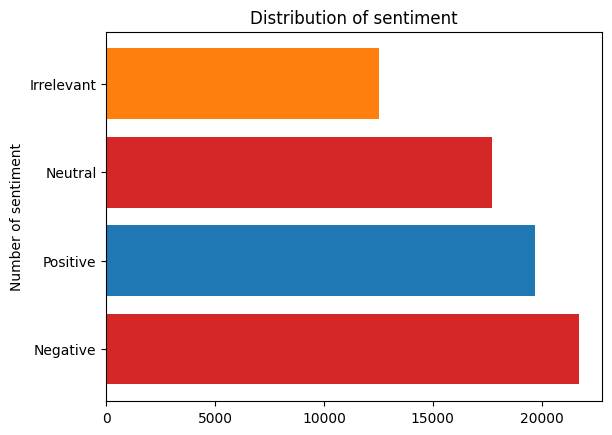

In [9]:
distribution_chart(sentiment_counts,'sentiment').show()

### NOTE
The sentiment column contains four categories with the following distribution:

* <b>Negative</b>: 21,698 entries

* <b>Positive</b>: 19,713 entries

* <b>Neutral</b>: 17,708 entries

* <b>Irrelevant</b>: 12,537 entries

This figure  shows that the sentiment column is imbalanced, with a higher representation of Negative sentiments (21,698 entries) compared to other categories. This imbalance might affect model performance, as some classes are less represented, potentially leading to biased predictions.


### Distribution of entity

/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_68974/2919378985.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(entity, 'entity').show()


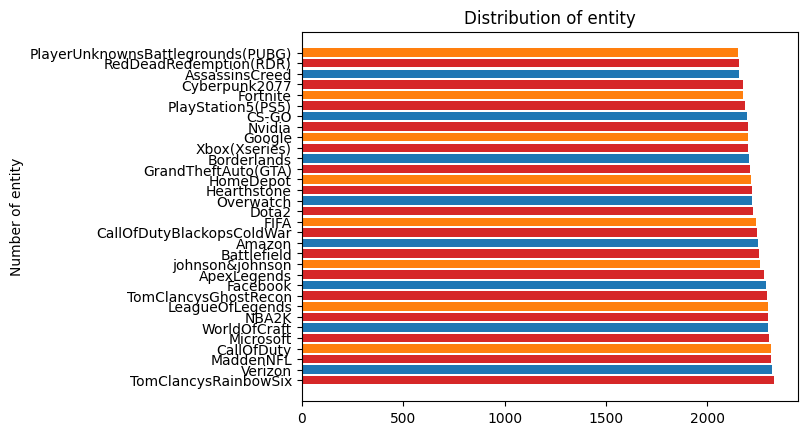

In [10]:
entity = df['entity'].value_counts()
distribution_chart(entity, 'entity').show()

### NOTE

The entity column shows a variety of entities, primarily brands, products, and popular video games. The distribution of the top entities is as follows:

* The most frequently mentioned entity is TomClancysRainbowSix with 2328 entries, followed closely by Verizon(2319), MaddenNFL (2315), and CallOfDuty (2314).
* Other notable entities include Microsoft (2304), NBA2K (2299), LeagueOfLegends (2296), Facebook (2289), and Amazon (2249).
* The lowest count among the top entities is PlayerUnknownsBattlegrounds(PUBG), with 2150 entries.

Overall, the entity counts are fairly balanced among the top entities, with each having around 2000 to 2300 entries. This uniform distribution across entities provides a broad dataset for analyzing sentiments related to a diverse set of brands and games.

### Distribution of sentiment by entity

/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_68974/621010469.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiment_distribution_chart(df, 'entity', 'sentiment').show()


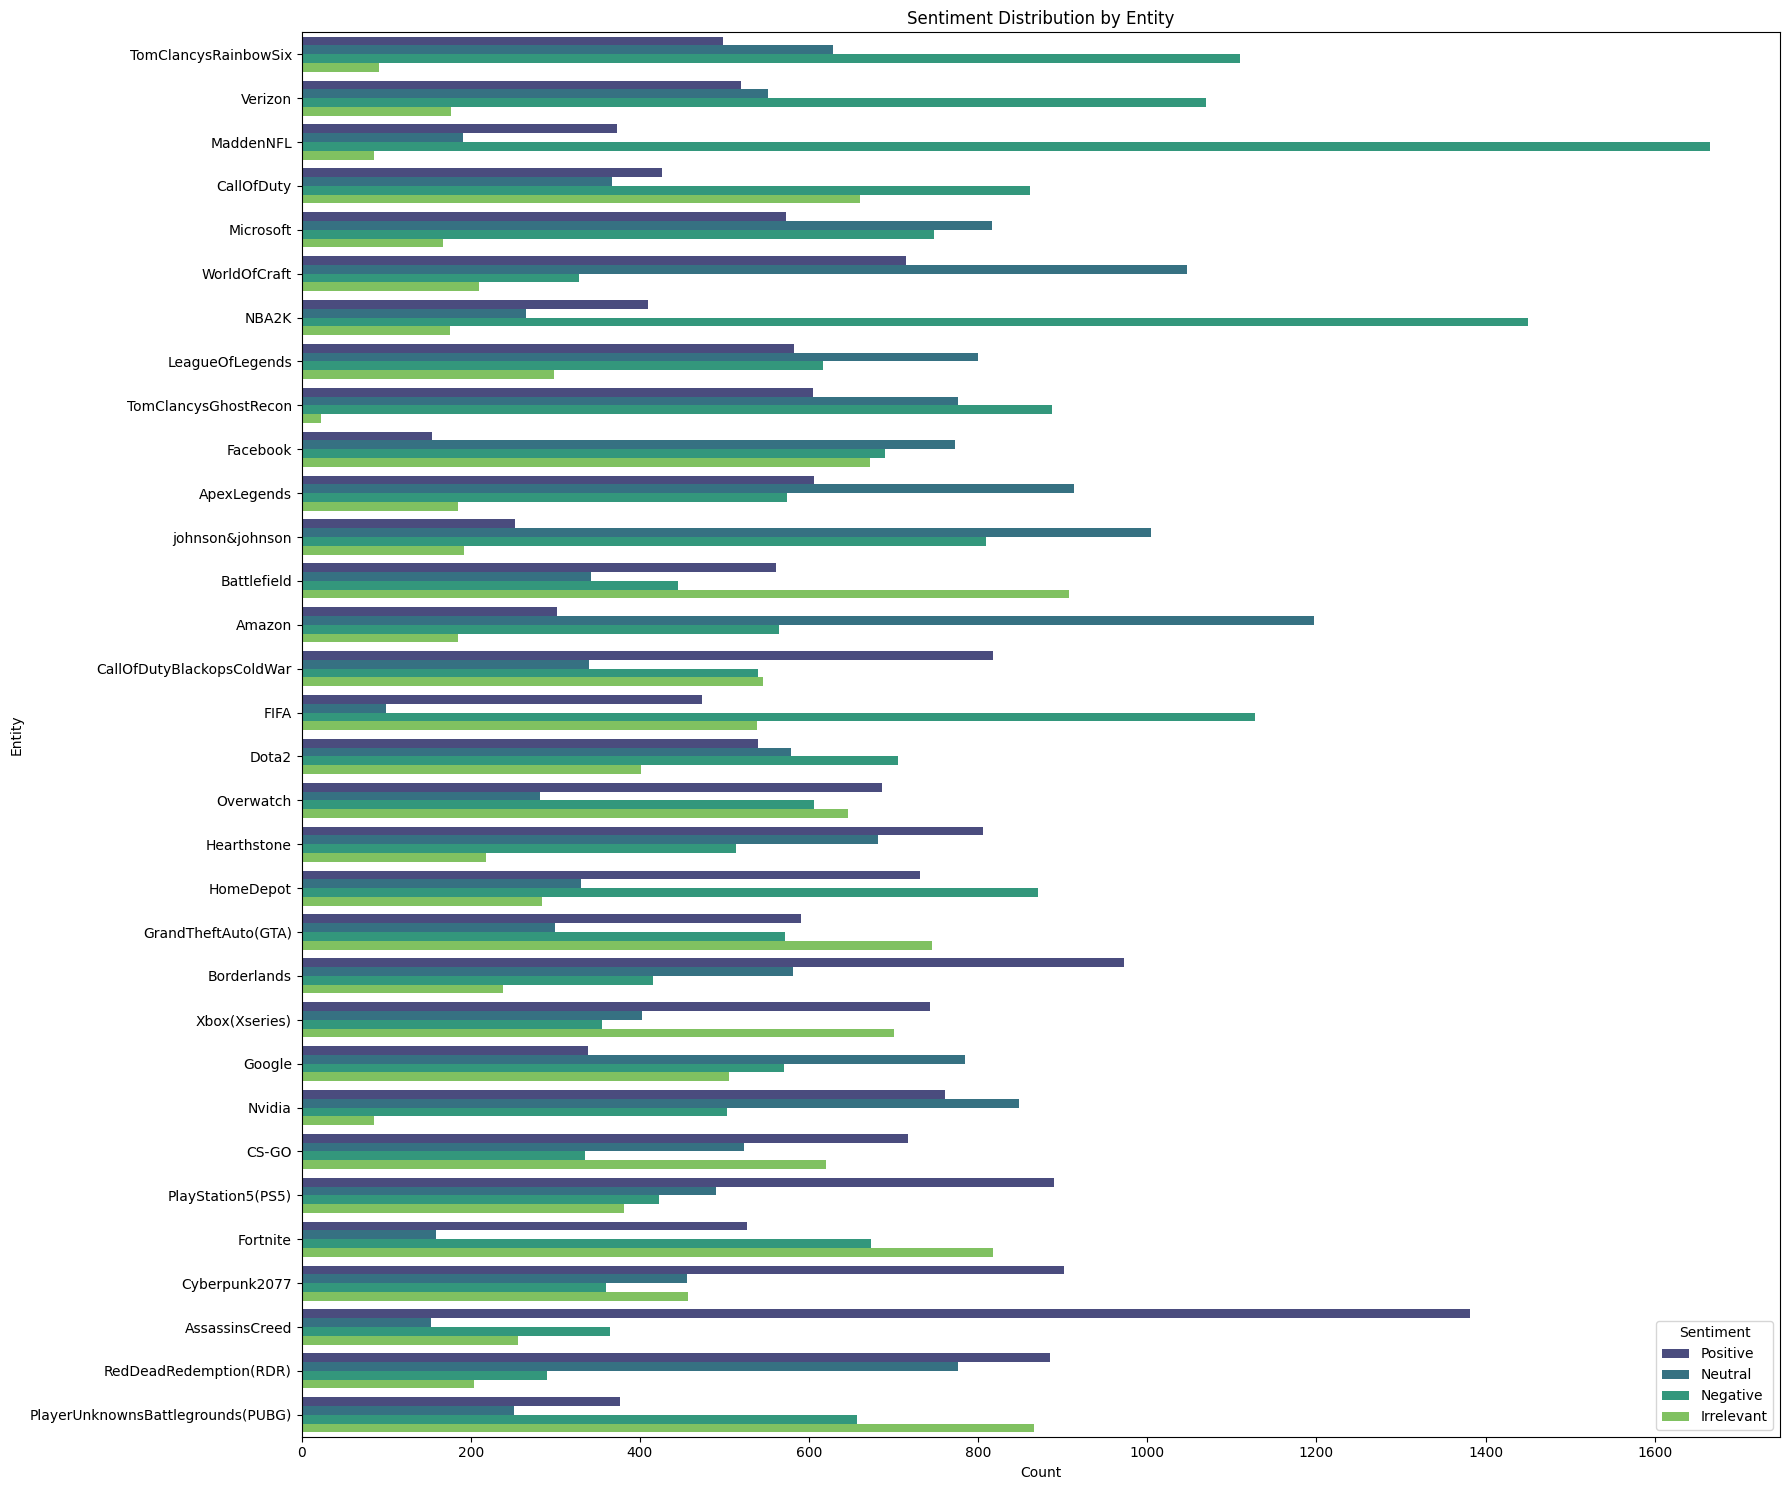

In [11]:
sentiment_distribution_chart(df, 'entity', 'sentiment').show()

### NOTE
Certain entities in the dataset are more likely to appear in tweets with specific sentiment types. Which can be a clue to the model in decision making.

### Word Cloud for each group sentiment 

/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_68974/4027139701.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()


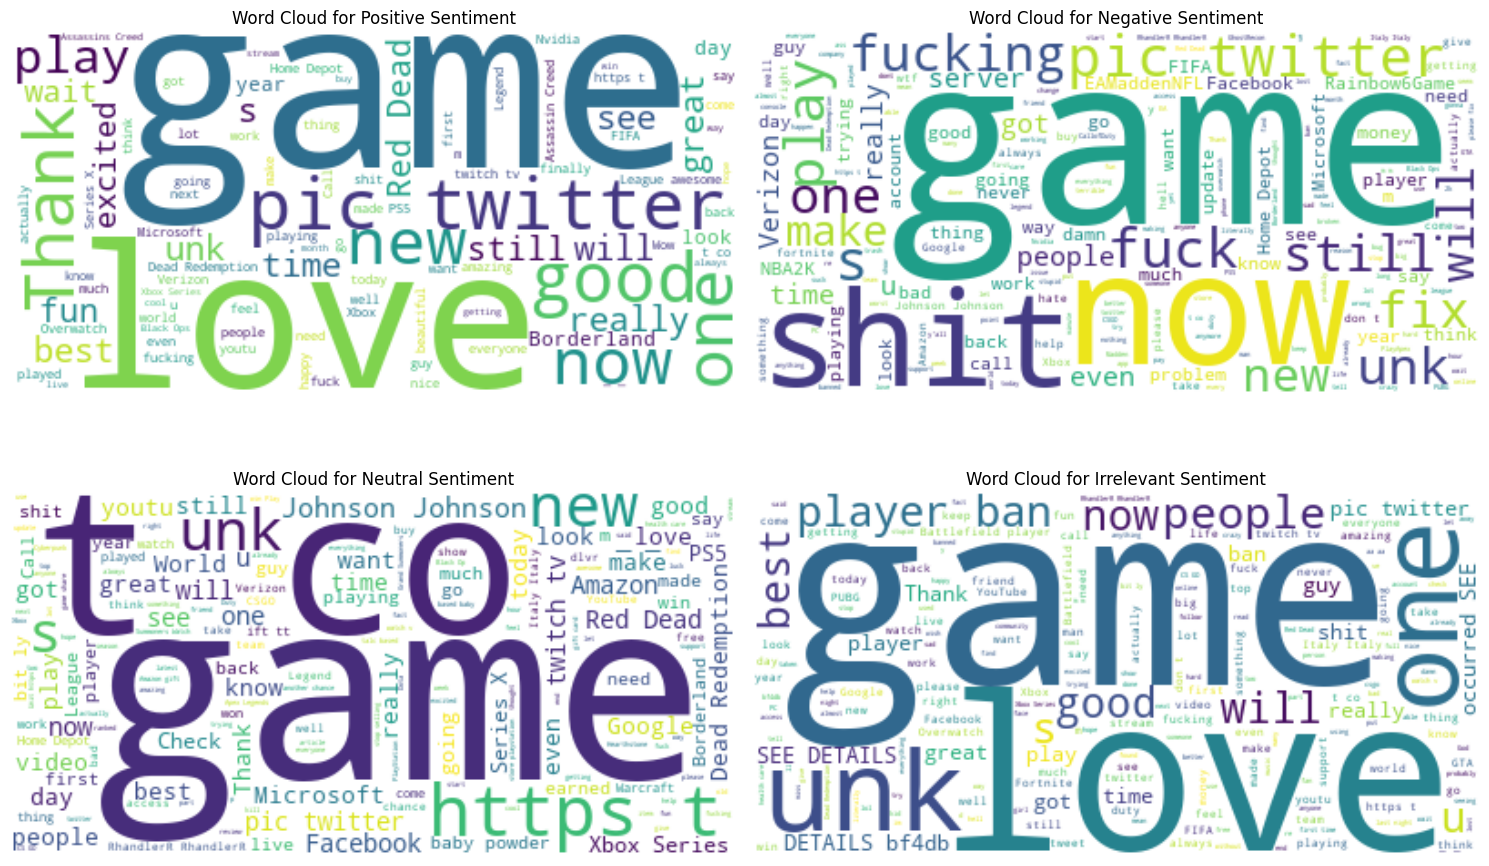

In [12]:
generate_sentiment_wordclouds(data=df,
                              sentiment_col='sentiment',
                              text_col='content',
                              sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()

### NOTE
Clearly, the word "game" is the most frequently used term across all four sentiment classes. We also note that non-informational words are also frequently used (e.g., will, http, unk, etc.). Therefore, it is necessary to clean the data from these words.

### Data preprocessing

In [13]:
# remove stop words
df['content'] = df['content'].apply(remove_stop_words)
# remove special characters
df['content']= df['content'].apply(remove_special_characters)
# remove digits
df['content']= df['content'].apply(removing_digits)
# convert text to lowercase
df['content']= df['content'].apply(convert_to_lowercase)
# remove extra space
df['content']= df['content'].apply(remove_extra_spaces)

### After removing stop words here could be problems with the empty content

In [14]:
print('Num of empty content samples:', sum(df['content'] == ''))
df = df[df['content'] != '']

Num of empty content samples: 1582


### The label column should be encoded

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [16]:
df['content_lemma'] = df['content'].apply(lambda text: normalization_text('lemmatization', text))
df['content_stemming'] = df['content'].apply(lambda text: normalization_text('stemming', text))
df['content_combo'] = df['content'].apply(lambda text: normalization_text('combo', text))

In [17]:
# Due to the computational complexity, we consider a subset of the dataset.
df_sub = get_subset(df, n_samples = 100, random_state = 42)

### Embeddings

We consider two ways of dealing with data: normalized data and non-normalized data. Among the data normalization approaches we consider stemming, lemmatization and combination( lemmatization + stemming)

In [18]:
train_test_split = partial(train_test_split, test_size=0.2, random_state=42)

# 4 variants for analysis

X_train, X_test, y_train, y_test = train_test_split(df_sub['content'], df_sub['sentiment'])
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(df_sub['content_lemma'], df_sub['sentiment'])
X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming = train_test_split(df_sub['content_stemming'], df_sub['sentiment'])
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(df_sub['content_combo'], df_sub['sentiment'])


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [19]:
data_processing_map = {
    'original': (X_train, X_test, y_train, y_test),
    'lemmatization': (X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma),
    'stemming': (X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming),
    'combination': (X_train_combo, X_test_combo, y_train_combo, y_test_combo),
}

vectorizers = (
    VectorizerType.FAST_TEXT,
    VectorizerType.W2V,
    VectorizerType.ONE_HOT,
    VectorizerType.TF_IDF,
)
classifications = (
    ClassicClassificationType.SVC,
    ClassicClassificationType.DECISION_TREE,
    ClassicClassificationType.RANDOM_FOREST,
    ClassicClassificationType.K_NEIGHBORS,
    )

In [20]:
results = []

for preprocessing_name, (X_train, X_test, y_train, y_test) in data_processing_map.items():

    for vectorizer_type in vectorizers:
        vectorizer = Vectorizer(vectorizer_type)
        vectorizer.fit(X_train)

        X_train_vec = np.array(vectorizer.transform(X_train))
        X_test_vec = np.array(vectorizer.transform(X_test))

        for classification_type in classifications:
            classificator = ClassicClassification(classification_type)
            classificator.fit(X_train_vec, y_train)

            y_pred = classificator.predict(X_test_vec)

            result = estimate_quality(y_test, y_pred)
            print(f'Preprocessing: {preprocessing_name}, Vectorizer: {vectorizer_type.name}, Classificator: {classification_type.name}')
            print(dump_dict(result, indent=4))

            results.append([preprocessing_name, vectorizer_type.name, classification_type.name, result['accuracy'], result['f1']])

result_frame = pd.DataFrame(results, columns=['Preprocessing', 'Vectorizer', 'Classificator', 'Accuracy', 'F1'])
print(result_frame)

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: SVC
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.59, 0.0, 0.0]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: DECISION_TREE
    accuracy: 0.3
    per_class_accuracy: [0.5, 0.25, 0.29, 0.33]
    f1: 0.3
    per_class_f1: [0.29, 0.29, 0.33, 0.29]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: RANDOM_FOREST
    accuracy: 0.35
    per_class_accuracy: [1.0, 0.38, 0.14, 0.33]
    f1: 0.35
    per_class_f1: [0.67, 0.4, 0.25, 0.18]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: K_NEIGHBORS
    accuracy: 0.55
    per_class_accuracy: [1.0, 1.0, 0.14, 0.0]
    f1: 0.55
    per_class_f1: [0.8, 0.73, 0.25, 0.0]

Preprocessing: original, Vectorizer: W2V, Classificator: SVC
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.57, 0.0, 0.0]

Preprocessing: original, Vectorizer: W2V, Clas

### NOTE

#### Preprocessing: Original

* FAST_TEXT vectorizer generally works better with K-NEIGHBORS (accuracy 0.55, per-class accuracy [1.0, 1.0, 0.14, 0.0]), though SVC has poor class balance (accuracy 0.4, per-class accuracy [0.0, 1.0, 0.0, 0.0]). The classifiers show inconsistent results with low F1 scores for several classes.
* W2V performs similarly across classifiers, with slightly higher accuracy in RANDOM_FOREST (0.4) and K-NEIGHBORS (0.45). 
* ONE_HOT encoding struggles overall, with the highest accuracy of 0.4 in RANDOM_FOREST. However, models fail to generalize well to all classes, and F1 scores reflect this.
* TF-IDF performs modestly with DECISION_TREE (accuracy 0.45), showing a fair balance between class predictions, though other classifiers struggle with low per-class accuracy.

#### Preprocessing: Lemmatization

* FAST_TEXT sees a slight improvement for DECISION_TREE (accuracy 0.35, balanced class-wise accuracy), but other classifiers don’t show major changes from the original data. SVC and K-NEIGHBORS still exhibit significant class imbalances.
* W2V performs well with DECISION_TREE (accuracy 0.55, per-class accuracy [0.5, 0.75, 0.43, 0.33]), showing an improved per-class F1 distribution. K-NEIGHBORS also performs relatively better, with balanced class-wise results.
* ONE_HOT performance remains mediocre, with DECISION_TREE achieving the highest accuracy (0.45), while SVC and K-NEIGHBORS fail to generalize.
* TF-IDF results are similar to the original data, with DECISION_TREE achieving the best performance (accuracy 0.45).

#### Preprocessing: Stemming

* FAST_TEXT performs worse here than with lemmatization, especially with SVC (accuracy 0.35) and K-NEIGHBORS (accuracy 0.4), showing low F1 scores and significant class imbalance.
* W2V continues to show moderate results across classifiers, with DECISION_TREE and K-NEIGHBORS offering slightly better performance than with lemmatization.
* ONE_HOT exhibits weak results again, with the best classifier being DECISION_TREE (accuracy 0.45), though class-wise accuracy is still problematic.
* TF-IDF produces the lowest performance across the board in this configuration.

#### Preprocessing: Combination
* FAST_TEXT performs significantly worse. The SVC classifier shows especially low accuracy at 0.35, while K-NEIGHBORS reaches a slightly higher but still low accuracy of 0.4.
* W2V (Word2Vec) achieves moderate results across classifiers, with a slight improvement in performance with DECISION_TREE and K NEIGHBORS. 
* ONE_HOT continues to yield weak results, with DECISION_TREE emerging as the highest-performing classifier with an accuracy of 0.45. 
* TF-IDF shows the lowest performance across all classifiers in this configuration, displaying consistently low accuracy and F1 scores. 

#### General Observations:

* K-NEIGHBORS generally performs best with FAST_TEXT and W2V vectorizers, achieving the highest accuracy (up to 0.55). However, its performance is inconsistent across underrepresented classes.
* DECISION_TREE shows balanced results with W2V vectorizer, especially after lemmatization (accuracy 0.55), and is the most consistent classifier in balancing class-wise performance.
* SVC tends to overfit on certain classes, especially with FAST_TEXT and W2V. It struggles to generalize to underrepresented classes.
* RANDOM_FOREST achieves moderate results but lacks consistency in handling all classes, often misrepresenting some with low F1 scores.
* ONE_HOT and TF-IDF vectorizers tend to perform the worst across classifiers, especially in handling class imbalance.
* Lemmatization combined with W2V and DECISION_TREE offers a good balance of accuracy and per-class performance.

## GridSearch

In [21]:
results_grid = []

preprocessing_name = 'original'
vectorizer_type = VectorizerType.W2V

X_train, X_test, y_train, y_test =  data_processing_map[preprocessing_name]

vectorizer = Vectorizer(vectorizer_type)
vectorizer.fit(X_train)

X_train_vec = np.array(vectorizer.transform(X_train))
X_test_vec = np.array(vectorizer.transform(X_test))

for classification_type in classifications:
    classificator = ClassicClassification(classification_type)
    classificator.grid_search(X_train_vec, y_train)

    y_pred = classificator.predict(X_test_vec)

    result = estimate_quality(y_test, y_pred)
    print(f'Best parameters of {classificator.classification_type.name}')
    print(dump_dict(classificator.best_params, indent=4))

    print(f'Best results:')
    print(dump_dict(result, indent=4))


    results_grid.append([preprocessing_name, vectorizer_type.name, classification_type.name, result['accuracy'], result['f1']])

results_grid_frame = pd.DataFrame(results_grid, columns=['Preprocessing', 'Vectorizer', 'Classificator', 'Accuracy', 'F1'])
print(results_grid_frame)

Best parameters of SVC
    C: 1
    gamma: 4

Best results:
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.57, 0.0, 0.0]

Best parameters of DECISION_TREE
    criterion: entropy
    max_depth: 5

Best results:
    accuracy: 0.35
    per_class_accuracy: [0.5, 0.62, 0.0, 0.33]
    f1: 0.35
    per_class_f1: [0.5, 0.53, 0.0, 0.25]

Best parameters of RANDOM_FOREST
    criterion: entropy
    max_depth: 10
    n_estimators: 50

Best results:
    accuracy: 0.35
    per_class_accuracy: [0.5, 0.62, 0.0, 0.33]
    f1: 0.35
    per_class_f1: [0.5, 0.53, 0.0, 0.2]

Best parameters of K_NEIGHBORS
    algorithm: ball_tree
    n_neighbors: 10
    weights: distance

Best results:
    accuracy: 0.45
    per_class_accuracy: [0.5, 1.0, 0.0, 0.0]
    f1: 0.45
    per_class_f1: [0.67, 0.64, 0.0, 0.0]

  Preprocessing Vectorizer  Classificator  Accuracy    F1
0      original        W2V            SVC      0.40  0.40
1      original        W2V  DECISION_

### NOTE 

#### Support Vector Classifier (SVC)

The SVC achieved an overall accuracy of 40%, but its performance was highly imbalanced across classes. It classified only one class (class 1) correctly with high precision, achieving a per-class accuracy of 1.0 for that class. However, for the other classes, it failed completely, with accuracy and F1 scores of 0. This suggests the SVC struggled with class imbalance.

#### Decision Tree

The Decision Tree classifier showed a slightly lower overall performance compared to SVC, with an accuracy of 35%. However, it showed more balanced performance across the classes. The model classified two classes with moderate success (class 0 and class 1), achieving F1 scores of 0.5 and 0.53, respectively, but completely failed to identify class 2.

#### Random Forest

The Random Forest classifier performs similarly to the Decision Tree, with identical accuracy (0.35) and similar per-class metrics. This result indicates that increasing the complexity of the model (via multiple trees) did not lead to significant performance improvement.

#### K-Neighbors Classifier

The K-Neighbors classifier yielded the highest accuracy (45%) among the tested models, with relatively good performance in classifying two classes (class 0 and class 1). However, similar to the other models, it failed to classify class 2 correctly. 

#### General Observations

* Across all models, the performance was heavily skewed towards class 1 and occasionally class 0, with class 2 performing poorly. This suggests a significant imbalance or difficulty in distinguishing between the classes in the dataset.
* The K-Neighbors classifier achieved the best overall results with 45% accuracy.


## Deep Learning approach

In [20]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [21]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.03,
    disable_tqdm=True,
)

In [22]:
models = [
    partial(LSTMClassifier, vocab_size=tokenizer.vocab_size, hidden_dim=512, num_layers=5, num_classes=num_classes, dropout=0.01),
    partial(RNNClassifier, vocab_size=tokenizer.vocab_size, hidden_dim=512, num_layers=5, num_classes=num_classes, dropout=0.01),
    partial(LSTMClassifier, vocab_size=tokenizer.vocab_size, hidden_dim=1024, num_layers=3, num_classes=num_classes, dropout=0.03),
    partial(RNNClassifier, vocab_size=tokenizer.vocab_size, hidden_dim=1024, num_layers=3, num_classes=num_classes, dropout=0.03),
    ]

In [23]:
results_dl = []

compute_metrics = partial(compute_metrics, num_classes=num_classes)
for preprocessing_name in data_processing_map:
    
    X_train, X_test, y_train, y_test = data_processing_map[preprocessing_name]
    train_dataset = prepare_dataset(X_train, y_train, tokenizer)
    eval_dataset = prepare_dataset(X_test, y_test, tokenizer)
    
    for model_init in models:
        model = model_init()

        print(f'\nTraining {model.get_name()} model')
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            processing_class=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()

        evaluate_results = trainer.evaluate()

        results_dl.append([model.get_name(),
                           model._modules['backbone'].hidden_size,
                           model._modules['backbone'].num_layers,
                           model._modules['dropout'].p,
                           preprocessing_name, evaluate_results['eval_loss'],
                           evaluate_results['eval_accuracy'],
                           evaluate_results['eval_f1']])

results_dl_frame = pd.DataFrame(results_dl, columns=['Model',
                                                     'hidden_size',
                                                     'num_layers',
                                                     'dropout',
                                                     'Preprocessing',
                                                     'Eval loss',
                                                     'Eval Acc',
                                                     'Eval f1'])
print(results_dl_frame)


Training LSTMClassifier model
{'eval_loss': 1.3896386623382568, 'eval_accuracy': 0.15000000596046448, 'eval_f1': 0.15000000596046448, 'eval_runtime': 0.0515, 'eval_samples_per_second': 388.07, 'eval_steps_per_second': 58.211, 'epoch': 1.0}
{'eval_loss': 1.389409065246582, 'eval_accuracy': 0.15000000596046448, 'eval_f1': 0.15000000596046448, 'eval_runtime': 0.0174, 'eval_samples_per_second': 1151.475, 'eval_steps_per_second': 172.721, 'epoch': 2.0}
{'eval_loss': 1.3893506526947021, 'eval_accuracy': 0.15000000596046448, 'eval_f1': 0.15000000596046448, 'eval_runtime': 0.0177, 'eval_samples_per_second': 1133.09, 'eval_steps_per_second': 169.964, 'epoch': 3.0}
{'train_runtime': 1.0608, 'train_samples_per_second': 226.245, 'train_steps_per_second': 28.281, 'train_loss': 1.3791224161783855, 'epoch': 3.0}
{'eval_loss': 1.3893506526947021, 'eval_accuracy': 0.15000000596046448, 'eval_f1': 0.15000000596046448, 'eval_runtime': 0.0172, 'eval_samples_per_second': 1160.684, 'eval_steps_per_second': 

In [24]:
results_dl_frame

,Model,hidden_size,num_layers,dropout,Preprocessing,Eval loss,Eval Acc,Eval f1
0,LSTMClassifier,512,5,0.01,original,1.389351,0.15,0.15
1,RNNClassifier,512,5,0.01,original,1.344243,0.40,0.40
2,LSTMClassifier,1024,3,0.03,original,1.384719,0.40,0.40
3,RNNClassifier,1024,3,0.03,original,1.305989,0.45,0.45
4,LSTMClassifier,512,5,0.01,lemmatization,1.374450,0.40,0.40
5,RNNClassifier,512,5,0.01,lemmatization,1.345104,0.40,0.40
6,LSTMClassifier,1024,3,0.03,lemmatization,1.384507,0.40,0.40
7,RNNClassifier,1024,3,0.03,lemmatization,1.310297,0.40,0.40
8,LSTMClassifier,512,5,0.01,stemming,1.374488,0.40,0.40
9,RNNClassifier,512,5,0.01,stemming,1.346301,0.45,0.45


### NOTE 

#### Model Performance
the RNN models shows a consistent performance advantage over the LSTM models by 5 percentage points, which is especially noticeable when using improved parameters (e.g., larger hidden layer size and reduced number of layers).

#### Impact of Preprocessing
The choice of preprocessing method appears to influence model performance:
* The stemming preprocessing results in consistent evaluation accuracy of 40% for both LSTM and RNN classifiers with 512 hidden size and 5 layers.
* The lemmatization method yields better results for the RNNClassifier, particularly with higher hidden size (1024) and fewer layers (3), indicating that lemmatization may help in generalizing better on the dataset.

#### Model Complexity

The LSTMClassifier with hidden size 512 and 5 layers using the original preprocessing has lower accuracy (15%) compared to the RNNClassifier with the same configuration (40%).

#### General Observations
The results suggest that preprocessing and model choice significantly impact the performance of sentiment analysis classifiers, with the RNNClassifier showing notable advantages in this task.

# Strategies for improving the metric

## 1. Normalization 

Using various text normalization strategies can enhance the metrics. Our experiments above have demonstrated and confirmed this.

#### LSTM

Regardless of the normalization technique (original, lemmatization, stemming, or combination), the LSTM models consistently demonstrate an accuracy of 40% across most configurations. 

#### RNN

The RNN classifiers show slightly better performance, particularly when using lemmatization and stemming:
With lemmatization, the RNNClassifier with 1024 hidden size and 3 layers achieves an evaluation accuracy of 40%.
With stemming, the same model configuration reaches an accuracy of 45%, indicating that stemming may have helped the model capture important features better than lemmatization in this case.


## 2. Data balancing 

The dataset shows an imbalance in the distribution of sentiment classes, meaning that certain classes, such as Negativeand Positive, have more entries compared to others, like Neutral or Irrelevant. This imbalance can lead to biased model predictions, as the model may tend to favor the more frequent classes while underperforming on the less represented ones. We address the class imbalance by reducing the dataset to match the smallest number of instances among the classes. 

In [25]:
# n_samples is selected so that the subset total size does not change
df_sub = get_subset(df, n_samples = 165, random_state = 42)

min_count = df_sub['sentiment'].value_counts().min()
balanced_df = df_sub.groupby('sentiment').apply(lambda x: x.sample(min_count, random_state=42))
balanced_df.reset_index(drop=True, inplace=True)

sentiment_counts = balanced_df['sentiment'].value_counts()
sentiment_counts

/var/folders/dv/f5hnt9ln76s58c5pnq899n6h0000gn/T/ipykernel_68974/1740081505.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df_sub.groupby('sentiment').apply(lambda x: x.sample(min_count, random_state=42))


sentiment
0    25
1    25
2    25
3    25
Name: count, dtype: int64

In [26]:
train_test_split = partial(train_test_split, test_size=0.2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(balanced_df['content'], balanced_df['sentiment'])
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(balanced_df['content_lemma'], balanced_df['sentiment'])
X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming = train_test_split(balanced_df['content_stemming'], balanced_df['sentiment'])
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(balanced_df['content_combo'], balanced_df['sentiment'])


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [27]:
data_processing_map = {
    'original': (X_train, X_test, y_train, y_test),
    'lemmatization': (X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma),
    'stemming': (X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming),
    'combination': (X_train_combo, X_test_combo, y_train_combo, y_test_combo),
}

In [28]:
results_dl = []

compute_metrics = partial(compute_metrics, num_classes=num_classes)
for preprocessing_name in data_processing_map:
    
    X_train, X_test, y_train, y_test = data_processing_map[preprocessing_name]
    train_dataset = prepare_dataset(X_train, y_train, tokenizer)
    eval_dataset = prepare_dataset(X_test, y_test, tokenizer)
    
    for model_init in models:
        model = model_init()

        print(f'\nTraining {model.get_name()} model')
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            processing_class=tokenizer,
            compute_metrics=compute_metrics,
        )
        trainer.train()

        evaluate_results = trainer.evaluate()

        results_dl.append([model.get_name(),
                           model._modules['backbone'].hidden_size,
                           model._modules['backbone'].num_layers,
                           model._modules['dropout'].p,
                           preprocessing_name, evaluate_results['eval_loss'],
                           evaluate_results['eval_accuracy'],
                           evaluate_results['eval_f1']])

results_dl_frame = pd.DataFrame(results_dl, columns=['Model',
                                                     'hidden_size',
                                                     'num_layers',
                                                     'dropout',
                                                     'Preprocessing',
                                                     'Eval loss',
                                                     'Eval Acc',
                                                     'Eval f1'])
print(results_dl_frame)


Training LSTMClassifier model
{'eval_loss': 1.3865160942077637, 'eval_accuracy': 0.30000001192092896, 'eval_f1': 0.30000001192092896, 'eval_runtime': 0.0176, 'eval_samples_per_second': 1133.534, 'eval_steps_per_second': 170.03, 'epoch': 1.0}
{'eval_loss': 1.386595606803894, 'eval_accuracy': 0.30000001192092896, 'eval_f1': 0.30000001192092896, 'eval_runtime': 0.0174, 'eval_samples_per_second': 1147.961, 'eval_steps_per_second': 172.194, 'epoch': 2.0}
{'eval_loss': 1.3866640329360962, 'eval_accuracy': 0.30000001192092896, 'eval_f1': 0.30000001192092896, 'eval_runtime': 0.0178, 'eval_samples_per_second': 1125.489, 'eval_steps_per_second': 168.823, 'epoch': 3.0}
{'train_runtime': 0.8112, 'train_samples_per_second': 295.847, 'train_steps_per_second': 36.981, 'train_loss': 1.386939493815104, 'epoch': 3.0}
{'eval_loss': 1.3866640329360962, 'eval_accuracy': 0.30000001192092896, 'eval_f1': 0.30000001192092896, 'eval_runtime': 0.0178, 'eval_samples_per_second': 1124.659, 'eval_steps_per_second'

In [29]:
results_dl_frame

,Model,hidden_size,num_layers,dropout,Preprocessing,Eval loss,Eval Acc,Eval f1
0,LSTMClassifier,512,5,0.01,original,1.386664,0.30,0.30
1,RNNClassifier,512,5,0.01,original,1.387951,0.30,0.30
2,LSTMClassifier,1024,3,0.03,original,1.381706,0.30,0.30
3,RNNClassifier,1024,3,0.03,original,1.376912,0.35,0.35
4,LSTMClassifier,512,5,0.01,lemmatization,1.386655,0.30,0.30
5,RNNClassifier,512,5,0.01,lemmatization,1.384493,0.30,0.30
6,LSTMClassifier,1024,3,0.03,lemmatization,1.381486,0.30,0.30
7,RNNClassifier,1024,3,0.03,lemmatization,1.368363,0.40,0.40
8,LSTMClassifier,512,5,0.01,stemming,1.386640,0.30,0.30
9,RNNClassifier,512,5,0.01,stemming,1.379030,0.25,0.25


### NOTE

#### Model Comparison:
Across all configurations, RNN classifiers generally perform better than LSTM classifiers. The best evaluation accuracy for RNNs is 45%, while LSTMs consistently achieve only 30% accuracy, regardless of the configuration.

The RNNClassifier with 1024 hidden size, 3 layers, and stemming preprocessing yields the highest evaluation accuracy (45%) and F1 score (0.45), indicating a strong performance.

#### Impact of Hidden Size and Number of Layers:
Increasing the hidden size from 512 to 1024 and reducing the number of layers from 5 to 3 does not significantly improve the LSTM classifiers’ performance; they maintain a constant accuracy of 30%.

For RNN classifiers, while a similar change results in a noticeable improvement in performance (from 35% to 45% accuracy), the overall impact is still limited for LSTM classifiers.

#### Normalization Techniques:

The RNN classifiers benefit from normalization, especially when using stemming or lemmatization. The RNNClassifier with lemmatization achieves an accuracy of 40% and an F1 score of 0.40, while stemming boosts the performance to 45%.

In contrast, all LSTM configurations yield the same evaluation metrics of 30% accuracy regardless of the preprocessing method used. This indicates that LSTMs might not effectively utilize the benefits of text normalization in this dataset.

#### Evaluation Loss:
The evaluation loss values are relatively close across configurations. However, lower loss values correlate with higher accuracy and F1 scores:

The best-performing RNNClassifier with stemming has the lowest loss of 1.365222, which aligns with its highest accuracy of 45%.

Loss values for LSTM classifiers remain consistently around 1.38, suggesting they are not learning effectively.

#### Combination Preprocessing:

The combination preprocessing does not provide a performance boost for either classifier type. Both LSTM and RNN classifiers achieve similar results as the original preprocessing, suggesting that combining multiple preprocessing techniques may not always yield improved results.

---------

# Conclusion

In this laboratory work, we consider on sentiment analysis on the dataset <a href="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data" target="_blank">  Twitter Sentiment Analysis </a>. Due to computational complexity, we consider a subset of 100 samples.

We have considered classical machine learning methods such as SVC, DECISION_TREE, RANDOM_FOREST, K_NEIGHBORS. We found that the best method was to use K_NEIGHBORS with vectorizer FAST_TEXT(0.55)

The experiments conducted on various NN classifiers (LSTM and RNN) demonstrated that RNN classifiers consistently outperform LSTM classifiers across all configurations. 

The use of different preprocessing techniques, in particular stacking and lemmatization, positively affects the performance of both classical algorithms(DECISION_TREE with lemmatization - 0.35%) and RNN classifiers, achieving a maximum estimation accuracy of 50% when using stebling. In contrast, LSTM classifiers show a stable performance, maintaining an accuracy of only 40% regardless of the preprocessing method used.

Balancing the dataset resulted in both a decrease(LSTMClassifier(hidden_size=512,num_layers=5, dropout=0.01)) in the metric and an increase(RNNClassifier(hidden_size=512,num_layers=5, dropout=0.01)). This ambiguous behavior may be due to the small dataset.
